# CAM_MNIST

- How to register a hook at targeted layer of network
- http://pytorch.org/docs/0.3.1/autograd.html?highlight=register_hook#torch.autograd.Variable.register_hook

## 1) Import required Libraries

In [1]:
import os

os.environ["CUDA_VISIBLE_DEVICES"]="0"

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.autograd import Variable

import torch.nn.functional as F
from skimage.transform import resize
import matplotlib.pyplot as plt
%matplotlib inline  

import random

## 2) Hyperparameters

In [2]:
batch_size = 256
learning_rate = 0.0001
num_epoch = 10

In [3]:
def one_sided_padding(x):
    rand1 = random.randrange(0,15,3)
    rand2 = random.randrange(0,15,3)

    zero = np.zeros(shape=[28,28,1])
    zero[rand1:rand1+12,rand2:rand2+12,:]=np.asarray(x).reshape(12,12,1)
    return zero

## 3) Dataloader

In [4]:
mnist_train = dset.MNIST("./", train=True, 
                         transform=transforms.Compose([
                            transforms.RandomCrop(22),
                            transforms.Resize(12),
                            transforms.Lambda(one_sided_padding),
                            transforms.ToTensor(),
                         ]), 
                         target_transform=None, 
                         download=True)

mnist_test = dset.MNIST("./", train=False,
                        transform=transforms.Compose([
                            transforms.RandomCrop(22),
                            transforms.Resize(12),
                            transforms.Lambda(one_sided_padding),
                            transforms.ToTensor(),
                        ]),
                        target_transform=None, 
                        download=True)

train_loader = torch.utils.data.DataLoader(mnist_train,batch_size=batch_size, shuffle=True,num_workers=2,drop_last=True)
test_loader = torch.utils.data.DataLoader(mnist_test,batch_size=batch_size, shuffle=True,num_workers=2,drop_last=True)

## 4) Classification Model

In [5]:
class CNN(nn.Module):
    def __init__(self,num_feature=32):
        super(CNN,self).__init__()
        self.num_feature=num_feature
        
        self.layer = nn.Sequential(
            nn.Conv2d(1,self.num_feature,3,1,1),
            nn.BatchNorm2d(self.num_feature),
            nn.ReLU(),
            nn.Conv2d(self.num_feature,self.num_feature*2,3,1,1),
            nn.BatchNorm2d(self.num_feature*2),
            nn.ReLU(),
            nn.AvgPool2d(2,2),
            
            nn.Conv2d(self.num_feature*2,self.num_feature*4,3,1,1),
            nn.BatchNorm2d(self.num_feature*4),
            nn.ReLU(),
            nn.AvgPool2d(2,2),
            
            nn.Conv2d(self.num_feature*4,self.num_feature*8,3,1,1),
            nn.BatchNorm2d(self.num_feature*8),
            nn.ReLU(),
        )
        self.fc_layer = nn.Sequential(
            nn.Linear(self.num_feature*8*7*7,1000),
            nn.ReLU(),
            nn.Linear(1000,10)
        )       
        
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                
                # Kaming Initialization
                init.kaiming_normal(m.weight.data)
                m.bias.data.fill_(0)
                
            elif isinstance(m, nn.Linear):

                # Kaming Initialization
                init.kaiming_normal(m.weight.data)
                m.bias.data.fill_(0)
        
        
    def forward(self,x):
        out = self.layer(x)
        out = out.view(x.size()[0],-1)
        out = self.fc_layer(out)

        return out

model = nn.DataParallel(CNN().cuda())

## 5) Loss & Optimizer

In [6]:
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

## 6) Train

In [7]:
for i in range(num_epoch):
    model.train()
    for j,[image,label] in enumerate(train_loader):
        x = Variable(image).cuda()
        y_= Variable(label).cuda()
        
        optimizer.zero_grad()
        output = model.forward(x)
        loss = loss_func(output,y_)
        loss.backward()
        optimizer.step()
        
         
    top_1_count = torch.FloatTensor([0])
    total = torch.FloatTensor([0])
    model.eval() 
    for image,label in test_loader:
        x = Variable(image,volatile=True).cuda()
        y_= Variable(label).cuda()

        output = model.forward(x)
        
        values,idx = output.max(dim=1)
        top_1_count += torch.sum(y_==idx).float().cpu().data

        total += label.size(0)

    print("Test Data Accuracy: {}%".format(100*(top_1_count/total).numpy()))
    if (top_1_count/total).numpy() > 0.98:
        break


Test Data Accuracy: [91.81691]%
Test Data Accuracy: [94.80168]%
Test Data Accuracy: [96.04367]%
Test Data Accuracy: [97.04527]%
Test Data Accuracy: [96.6246]%
Test Data Accuracy: [97.53606]%
Test Data Accuracy: [96.55449]%
Test Data Accuracy: [97.82652]%
Test Data Accuracy: [97.15545]%
Test Data Accuracy: [95.99359]%


## 7) CAM 

In [8]:
class CAM():
    def __init__(self,model):
        self.gradient = []
        self.h = model.module.layer[-1].register_backward_hook(self.save_gradient)
        
    def save_gradient(self,*args):
        grad_input = args[1]
        grad_output= args[2]
        self.gradient.append(grad_output[0])
      
    def get_gradient(self,idx):
        return self.gradient[idx]
    
    def remove_hook(self):
        self.h.remove()
            
    def normalize_cam(self,x):
        x = 2*(x-torch.min(x))/(torch.max(x)-torch.min(x)+1e-8)-1
        x[x<torch.max(x)]=-1
        return x
    
    def visualize(self,cam_img,img_var):
        cam_img = resize(cam_img.cpu().data.numpy(),output_shape=(28,28))
        x = img_var[0,:,:].cpu().data.numpy()

        plt.subplot(1,3,1)
        plt.imshow(cam_img)

        plt.subplot(1,3,2)
        plt.imshow(x,cmap="gray")

        plt.subplot(1,3,3)
        plt.imshow(x+cam_img)
        plt.show()
    
    def get_cam(self,idx):
        grad = self.get_gradient(idx)
        alpha = torch.sum(grad,dim=3,keepdim=True)
        alpha = torch.sum(alpha,dim=2,keepdim=True)
        
        cam = alpha[j]*grad[j]
        cam = torch.sum(cam,dim=0)
        cam = self.normalize_cam(cam)
        
        self.remove_hook()
        return cam
   

## 8) Calculate & Visualize

/home/ubuntu/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


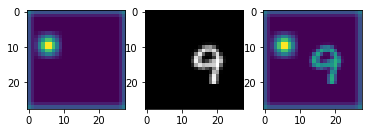

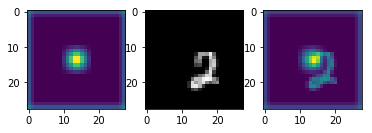

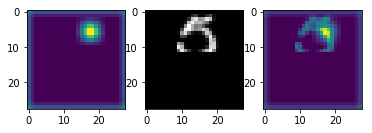

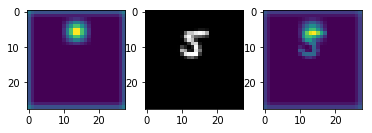

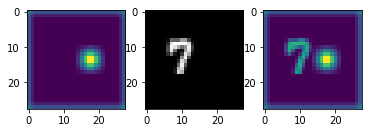

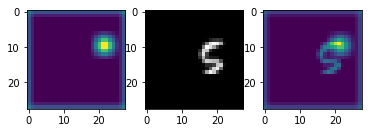

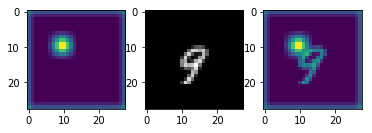

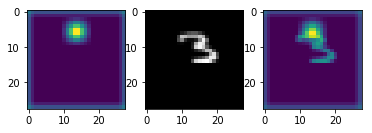

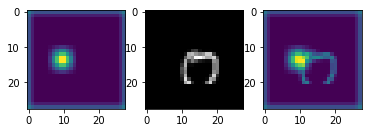

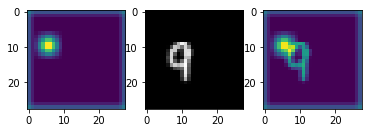

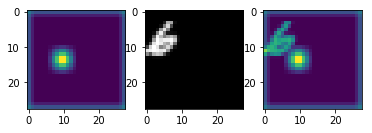

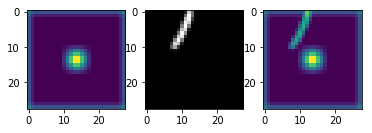

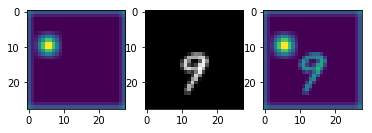

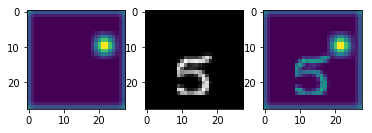

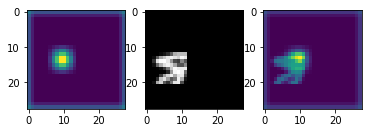

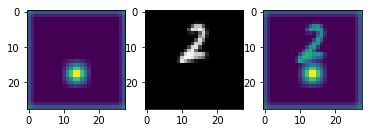

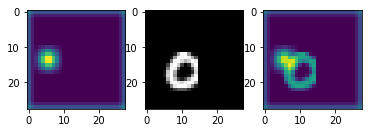

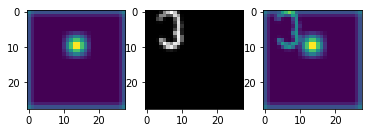

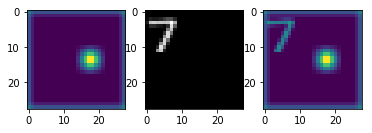

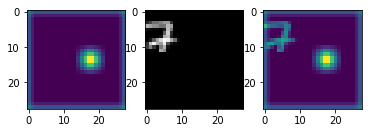

In [9]:
cam = CAM(model)

for i,[image,label] in enumerate(test_loader):
    x = Variable(image).cuda()
    y_= Variable(label).cuda()
        
    output = model.forward(x)    
    
    for j in range(20):
        model.zero_grad()
        lab = y_[j].cpu().data[0]
        output[j,lab].backward(retain_graph=True)

        out = cam.get_cam(j)
        cam.visualize(out,x[j])

    break